410411325_林皓翔, 410411239_陳宇凱, 410411245_陳本預

# Machine Learning  Face Recognition

先載入我們需要用到的packages：
<li>numpy - 可以用來處理多維陣列的運算</li>
<li>matplotlib - 則分別用來讀入圖片與繪圖</li>
<li>os - 提供了許多的方法來處理文件和目錄</li>
<li>cv2 - 在影像處理上十分好用的一個套件</li>
<li>sklearn - 提供了大部分機器學習方法的模組</li>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC

<p>因為我們所有的人臉圖片都放在同一資料夾，</p>
<p>如果全部拿去訓練的話很難檢驗模型是否有overfitting的情形，</p>
<p>所以必須寫一個程式去將檔案分成訓練資料和測試資料兩部分。</p>
<p>　　</p>
<p>Face Database:</p>
<p>　　有50個人，每人有13照片，總共650張jpg圖檔，且檔案名稱有次序(一個人13張完才會換下一人)</p>
<p>　　</p>
<p>Random testing-labels generator algorithm:</p>
<p>　　先造一個 0~12的ndarray當作母體，使用 np.random.choice 從中抽取兩個不重複的數字當作測試資料集的index。</p>
<p>　　等一下讀檔時會依資料夾內檔案名稱的順序依序讀入，如果用一個計數器從0開始每讀一張就+1，</p>
<p>　　則0~12對應到的就是第一個人的13張相片，如果index有被抽出就歸為測試資料，沒有就放入訓練資料。</p>
<p>　　接著將母體的編號全部加上13，即下一個人所對應到的index，一直重複上述操作直到50人都抽完為止。</p>
<p>　　如果改成一次抽3個數字，則每人就保留3張作為測試資料。</p>

In [2]:
def get_testing_label():
    testlab = []
    label = np.arange(0,13)
    for i in range(50):
        a = np.random.choice(label, 2, replace=False)
        testlab.append(a)
        label += 13
    testlab = np.array(testlab)
    testlab = testlab.reshape(-1)
    return testlab

testing_label = get_testing_label()

<p>將檔案存放的資料夾路徑以字串的型態指派給變數PATH</p>
<p>因為'\'是字串的跳脫字元，所以要改用'/'取代，</p>
<p>或著是在'\'再加一個反斜線讓其對下一個反斜線也採替代解釋 "\\"</p>
<p>　　</p>
<p>如果希望在Run time讓使用者輸入檔案存放路徑的話可採用以下寫法</p>
<p>　　PATH = input("輸入訓練資料集所在的路徑位址: ") + "\\"</p>

In [3]:
PATH = "C:/Users/sunny/Desktop/Face Database/"

<p>先display張原始的圖片出來看看</p>

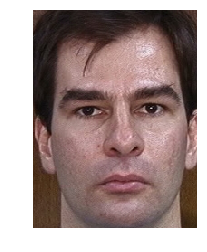

In [4]:
img = mpimg.imread(PATH + "s01_01.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

<p>建立四個空的list</p>
<p>　　X_train 存放訓練資料的圖像  y_train 則是對應的人的ID編號</p>
<p>　　X_test  存放測試資料的圖像  y_test  同樣為其對應的ID編號</p>
<p>　　</p>
<p>讓 file 依序為PATH路徑下的檔案名稱進行迴圈</p>
<p>每次迴圈都將該名稱的圖檔用 mpimg.imread 讀入</p>
<p>用cv2套件將其轉換成灰度圖，並透過立方內插法將每張圖片都調成相同的尺寸</p>
<p>size:(213,311)的選擇詳見 Data Input/ImportingGraph_TestAndReport 資料夾下的說明</p>
<p>再來用ndarray.reshape(-1)轉換成一為陣列後併入適當的list內</p>
<p>　　</p>
<p>Face Database資料集下的檔案名稱都採用相同的形式，s01_01.jpg，這是第一個人的第一張圖檔</p>
<p>所以這邊取檔案名稱的第二第三個字元轉換成數字後當作我們圖片所對應的ID</p>

In [5]:
X_train = []; y_train = []; X_test = []; y_test = []; i = 0;
for file in os.listdir(PATH):
    img = mpimg.imread(PATH + file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.resize(img_gray,(213,311),interpolation=cv2.INTER_CUBIC)
    img_gray = img_gray.reshape(-1)                   #轉換為一維陣列方便等下進行學習
    label = int(file[1:3])
    if i in testing_label:                            #如果index i 屬於前面產生的testing_index集合
        X_test.append(img_gray)                       #就把處理好的圖片與對應label併進測試資料集
        y_test.append(label)
    else:                                             #否則併入訓練資料集
        X_train.append(img_gray)
        y_train.append(label)
    i += 1

<p>將四個list都轉換成ndarray的資料型態</p>

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

<p>再把前面的照片秀出來一次，看經過我們處理後變成怎麼樣了</p>

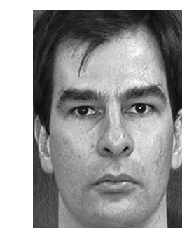

ID: 1


In [7]:
img = X_train[0].reshape((311,213))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.show()
print("ID:",y_test[0])

<p>現在訓練與測試用的資料都準備好了，</p>
<p>不過在使用辨識器進行學習前我們先用sklearn下的PCA套件進行維度的化簡，</p>
<p>不僅可以加快學習的速度，對辨識率的提升通常也有幫助。</p>
<p>由於人臉的特徵較為複雜，且每次作為測試資料的圖片不盡相同，</p>
<p>如果選擇降到較低的特定維度表現不太穩定，e.g.有時降到60維有很好的辨識率，但有時又會突然比鄰近的其他維度差上一截，</p>
<p>所以這邊選擇比較保守的作法，讓其仍保有足以解釋97%變異的能力。</p>

In [8]:
pca = PCA(n_components=0.97 , svd_solver='full')
newX_train = pca.fit_transform(X_train)
newX_test = pca.transform(X_test)

<p>再來使用SVC(Support Vector Classification)進行模型的訓練與辨識，核函數使用線性即可獲得不錯的成果了。</p>
<p>配適完後重新對訓練資料進行預測看我們對訓練資料的辨識率，同時更關注的是對未經訓練的測試資料能有多高的辨識率。</p>

In [9]:
clf = SVC(kernel = 'linear')
clf.fit(newX_train, y_train)
predict_train = clf.predict(newX_train)
predict_test = clf.predict(newX_test)
print("訓練資料辨識率:",np.mean(predict_train == y_train))
print("測試資料辨識率:",np.mean(predict_test == y_test))

訓練資料辨識率: 1.0
測試資料辨識率: 0.89


<p>這邊寫了一個小程式，想隨機看個幾張辨識成果的話輸入想display出來的張數則可。</p>

Enter the number of results you want to display: 3


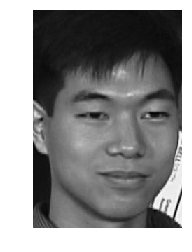

辨識結果: [27]

實際ID: 27


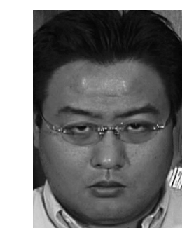

辨識結果: [40]

實際ID: 40


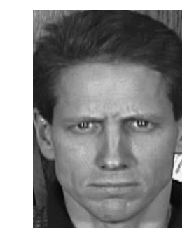

辨識結果: [45]

實際ID: 45


In [10]:
def get_display_label(n):
    displaylabel = []
    labelrange = np.arange(len(y_test))
    displaylabel = np.random.choice(labelrange, n, replace=False)
    return displaylabel

n = int(input("Enter the number of results you want to display: "))
display_index = get_display_label(n)
for i in display_index:
    img = X_test[i].reshape((311,213))
    plt.imshow(img, cmap='Greys_r')
    plt.axis('off')
    plt.show()
    print("辨識結果:",clf.predict(newX_test[i].reshape(1, -1)))
    print("\n實際ID:",y_test[i])

<p>可以載入collections.Counter的模組幫我們統計一下預測結果中每個人出現了幾次，</p>
<p>訓練資料集達到了100%的辨識率，與每個人為11次的結果相符</p>
<p>而從測試資料的統計中我們可以發現，每個人才兩張照片但4號就被預測出了4次，這人可能長的挺厲害的。</p>

In [11]:
from collections import Counter
print(Counter(predict_train))
print(Counter(predict_test))

Counter({1: 11, 2: 11, 3: 11, 4: 11, 5: 11, 6: 11, 7: 11, 8: 11, 9: 11, 10: 11, 11: 11, 12: 11, 13: 11, 14: 11, 15: 11, 16: 11, 17: 11, 18: 11, 19: 11, 20: 11, 21: 11, 22: 11, 23: 11, 24: 11, 25: 11, 26: 11, 27: 11, 28: 11, 29: 11, 30: 11, 31: 11, 32: 11, 33: 11, 34: 11, 35: 11, 36: 11, 37: 11, 38: 11, 39: 11, 40: 11, 41: 11, 42: 11, 43: 11, 44: 11, 45: 11, 46: 11, 47: 11, 48: 11, 49: 11, 50: 11})
Counter({31: 4, 1: 3, 9: 3, 10: 3, 27: 3, 38: 3, 36: 3, 48: 3, 2: 2, 4: 2, 45: 2, 6: 2, 7: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 28: 2, 29: 2, 30: 2, 32: 2, 33: 2, 34: 2, 35: 2, 37: 2, 40: 2, 42: 2, 43: 2, 44: 2, 47: 2, 49: 2, 50: 2, 3: 1, 5: 1, 8: 1, 18: 1, 19: 1, 39: 1, 46: 1})


<p>如果想更深入的了解辨識器的識別情況，我們可以列出混淆矩陣(Confusion Matrix)來看每個人被辨識的結果，</p>
<p>混淆矩陣的row name是圖片實際的類別(ID)，column name是預測的類別，而每一格的值是統計的次數。</p>
<p>一樣在sklearn中就有現成的函數可以幫我們製作了，不過因為總共有50個類別，50by50的矩陣相當不易閱讀，</p>
<p>這邊將其存入資料框(DataFrame)後以較精美的表格呈現。</p>

In [12]:
from sklearn.metrics import confusion_matrix
import pandas as pd
C = confusion_matrix(y_test,predict_test)
Confusion_Matrix = pd.DataFrame(C)
Confusion_Matrix.index = range(1,51)
Confusion_Matrix.columns = range(1,51)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
def highlight(data):
    return ('background-color: yellow' if data!=0 else "")
Confusion_Matrix.style.applymap(highlight)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<p>可以發現41號兩張都沒成功辨識出來，把他們在測試資料集的照片印出來看看是不是真的長很像</p>

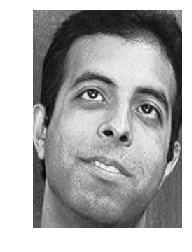

辨識結果: [10]

實際ID: 41


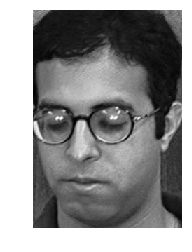

辨識結果: [1]

實際ID: 41


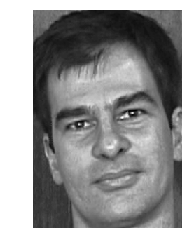

辨識結果: [1]

實際ID: 1


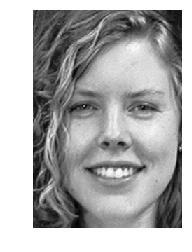

辨識結果: [10]

實際ID: 10


In [13]:
for i in range(80,82):
    img = X_test[i].reshape((311,213))
    plt.imshow(img, cmap='Greys_r')
    plt.axis('off')
    plt.show()
    print("辨識結果:",clf.predict(newX_test[i].reshape(1, -1)))
    print("\n實際ID:",y_test[i])
for i in (0,18):
    img = X_test[i].reshape((311,213))
    plt.imshow(img, cmap='Greys_r')
    plt.axis('off')
    plt.show()
    print("辨識結果:",clf.predict(newX_test[i].reshape(1, -1)))
    print("\n實際ID:",y_test[i])

<p>老實說這預測的結果其實還差蠻多的，男生都變成女生去了(汗)，</p>
<p>但單看41號的這兩張圖片確實很難當作是同一個人，辨識器會學的不好也是有些道理的。</p>
<p>不過這也代表我們還有著可以進步改善的空間，還是有許多的方法值得我們去嘗試的!!</p>